## Feature engineering

El objetivo de este notebook es generar nuevas variables a partir de las analizadas. Tambíen se hará una breve exploración para determinar si son variables que pueden ser importantes para el modelo.

### Import de los paquetes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
precision_recall_fscore_support
)
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

### Configuraciones

In [2]:
np.random.seed(42)

In [3]:
pd.set_option("display.max_columns", None)

### Helpers

In [4]:
def plot_confusion_matrix(cm: np.ndarray, classes: list):
    """
    Plots a confusion matrix.

    Args:
        cm (np.ndarray): The confusion matrix.
        classes (list): The class labels.

    Returns:
        None
    """
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f"
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()


def plot_roc_curve(y_test: np.ndarray, y_proba: np.ndarray):
    """
    Plots the ROC curve.

    Args:
        y_test (np.ndarray): The true labels.
        y_proba (np.ndarray): The predicted probabilities.

    Returns:
        None
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

### Carga de datos

In [5]:
df = pd.read_csv("../data/processed/dataset_training_v0.csv")
df.shape

(2962, 18)

In [6]:
df.head()

,invoiceId,businessId,payerId,relationDays,relationRecurrence,issuerCancelledInvoices,diasActividadPagador,facturaMorosa,montoFacturaWsz,issuerInvoicesAmountWsz,Clients12MonthsWsz,payerAmountFacturas,payerRatioMorosidad,payerAvgAmountFacturas,payerAvgDiasMora,payerDesvAmount,businessRatioMororsidad,businessAvgDiasMora
0,11654,5,5015,428.0,10.166667,0.021942,2632.0,1,4713103.0,187036960.0,4.0,181609529.0,0.400000,4035767,2.266667,677336.0,0.000000,0.000000
1,13430,5,5015,455.0,9.891304,0.020079,2659.0,0,7879645.0,231623853.0,4.0,210861531.0,0.423077,4055029,2.865385,3824616.0,1.000000,18.000000
2,15957,5,5015,493.0,9.264151,0.016629,2697.0,1,1190417.0,272695026.0,4.0,261505599.0,0.348485,3962206,6.348485,-2771789.0,0.500000,6.000000
3,18135,5,5015,542.0,9.016667,0.014322,2746.0,0,189924.0,321318559.0,3.0,278112178.0,0.375000,3862669,7.041667,-3672745.0,0.666667,4.333333
4,19438,5,5015,562.0,8.920635,0.013314,2766.0,0,3755846.0,346234215.0,3.0,297456818.0,0.376623,3863075,6.181818,-107229.0,0.500000,3.250000


### Split del conjunto de entrenamiento

In [7]:
# Ordenamos los datos
df = df.sort_values("invoiceId").copy()
df.drop(columns=["invoiceId", "businessId", "payerId"], inplace=True)

# Especificar las características (X) y el objetivo (y)
x = df.drop(columns=["facturaMorosa"], axis=1)
y = df["facturaMorosa"]

# Obtener las últimas 150 filas para validación
x_val = x.iloc[-300:]
y_val = y.iloc[-300:]

# Eliminar las últimas 150 filas de x e y
x = x.iloc[:-300]
y = y.iloc[:-300]

# Dividir el conjunto en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=15
)


# Verificamos las formas de los conjuntos resultantes
print("Formas de los conjuntos:")
print("Entrenamiento:", x_train.shape, y_train.shape)
print("Prueba:", x_test.shape, y_test.shape)
print("Validación:", x_val.shape, y_val.shape)


# Mostrar las formas de las particiones
print("Forma de x_train:", x_train.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Formas de los conjuntos:
Entrenamiento: (2395, 14) (2395,)
Prueba: (267, 14) (267,)
Validación: (300, 14) (300,)
Forma de x_train: (2395, 14)
Forma de x_val: (300, 14)
Forma de x_test: (267, 14)
Forma de y_train: (2395,)
Forma de y_val: (300,)
Forma de y_test: (267,)


In [8]:
# Creamos un diccionario donde guardamos todo el conjunto de datos
datasets = {
    "train": (x_train, y_train),
    "test": (x_test, y_test),
    "val": (x_val, y_val),
}

### Evaluamos distintos modelos

#### Funciones auxiliares

In [9]:
def track_metrics(pipeline, x: np.ndarray, y: np.ndarray, set_name: str = "test", threshold: float = 0.5):
    """
    Tracks metrics for a classification pipeline.

    Args:
        pipeline: The classification pipeline.
        x (np.ndarray): The input features.
        y (np.ndarray): The true labels.
        set_name (str): The name of the dataset (default: "test").
        threshold (float): The threshold for prediction (default: 0.5).

    Returns:
        None
    """
    # Predict probabilities
    y_proba = pipeline.predict_proba(x)[:, 1]

    # Apply the threshold
    y_pred = (y_proba >= threshold).astype(int)

    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)

    # Calculate metrics
    cm = confusion_matrix(y, y_pred)

    # Print classification report
    report = classification_report(y, y_pred, target_names=["Negative", "Positive"])
    print(f"Classification Report:\n{report}")
    report = classification_report(y, y_pred, target_names=["Negative", "Positive"])

    # Calculate precision, recall, f1-score, and support for each class using output_dict
    metrics_dict = precision_recall_fscore_support(y, y_pred, average=None, labels=[0, 1])

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(cm, classes=["Negative", "Positive"])
    plt.title(f"Confusion Matrix")

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plot_roc_curve(y, y_proba)
    plt.show()

    # Return metrics as a dictionary
    metrics = {
        f"{set_name}_Precision (Negative)": round(metrics_dict[0][0], 2),
        f"{set_name}_Precision (Positive)": round(metrics_dict[0][1], 2),
        f"{set_name}_Recall (Negative)": round(metrics_dict[1][0], 2),
        f"{set_name}_Recall (Positive)": round(metrics_dict[1][1], 2),
        f"{set_name}_F1-Score (Negative)": round(metrics_dict[2][0], 2),
        f"{set_name}_F1-Score (Positive)": round(metrics_dict[2][1], 2),
        f"{set_name}_Accuracy": round(accuracy, 2)
    }

    return metrics

In [10]:
def run_experiments(models: list, datasets: dict, run_params: dict = None, save_csv: bool = True):
    """
    Runs experiments for multiple models.

    Args:
        models (list): A list of tuples containing the model class and model parameters.
        datasets (dict): A dictionary containing the datasets for training, testing, and validation.
        run_params (dict): Additional parameters for the experiment runs (default: None).
        save_csv (bool): Whether to save metrics to CSV files (default: False).

    Returns:
        None
    """
    x_train, y_train = datasets["train"]
    x_test, y_test = datasets["test"]
    x_val, y_val = datasets["val"]

    for model in models:
        # Initialize the run
        model_name = model.__name__
        print("=" * 78)
        print(f"Starting experiment for model: {model_name}.")
        print("=" * 78)

        try:
            steps = [("scaler", StandardScaler()), ("model", model())]
            pipeline = Pipeline(steps=steps)

            # Entrenamiento del modelo
            pipeline.fit(x_train, y_train)

            # Tracking de métricas
            print("=" * 78)
            print("METRICAS EN TESTING SET")
            print("=" * 78)
            metrics_test = track_metrics(
                pipeline,
                x_test,
                y_test,
                set_name="test",
                threshold=run_params["threshold"],
            )

            # Tracking de métricas
            print("=" * 78)
            print("METRICAS EN VALIDATION SET")
            print("=" * 78)
            metrics_val = track_metrics(
                pipeline,
                x_val,
                y_val,
                set_name="val",
                threshold=run_params["threshold"],
            )

            if save_csv:
                # Guardar métricas en CSV
                save_metrics_to_csv(metrics_test, metrics_val, model_name)

        except Exception as e:
            print(e)

        finally:
            print("Experimento completado.")

def save_metrics_to_csv(metrics_test, metrics_val, model_name):
    # Obtén el timestamp actual como parte del nombre del archivo
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Definir el nombre del archivo CSV con el timestamp
    csv_filename = f"../metrics/experiments.csv"

    try:
        # Intentar cargar el archivo CSV existente
        df_existing = pd.read_csv(csv_filename)
    
        # Crear DataFrames de pandas con las métricas de test y validación
        df_test = pd.DataFrame([metrics_test])
        df_val = pd.DataFrame([metrics_val])

        df_combined = pd.concat([df_test, df_val], axis=1)
        df_combined["run_timestamp"] = timestamp
    
        # Concatenar el DataFrame existente con los DataFrames de test y validación
        frames = [df_existing, df_combined]
        df_existing = pd.concat(frames, axis=0)
    
        # Guardar el DataFrame actualizado como un archivo CSV
        df_existing.to_csv(csv_filename, index=False)
        print(f"Nuevas métricas agregadas y guardadas en {csv_filename}")

    except FileNotFoundError:
        # Si el archivo no existe, simplemente guarda las métricas como un nuevo archivo
        df_test = pd.DataFrame([metrics_test])
        df_val = pd.DataFrame([metrics_val])

        df_combined = pd.concat([df_test, df_val], axis=1)
        df_combined["run_timestamp"] = timestamp
        df_combined.to_csv(csv_filename, index=False)
        print(f"Archivo CSV creado y métricas guardadas en {csv_filename}")

#### Configuración de los experimentos

In [11]:
# Para remover el sampleo remplazar los string con None
params = {
    "threshold": 0.5,
}

In [12]:
models = [DecisionTreeClassifier, XGBClassifier, RandomForestClassifier, GradientBoostingClassifier]

Starting experiment for model: DecisionTreeClassifier.
METRICAS EN TESTING SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.64      0.67       157
    Positive       0.54      0.59      0.56       110

    accuracy                           0.62       267
   macro avg       0.61      0.62      0.61       267
weighted avg       0.63      0.62      0.62       267



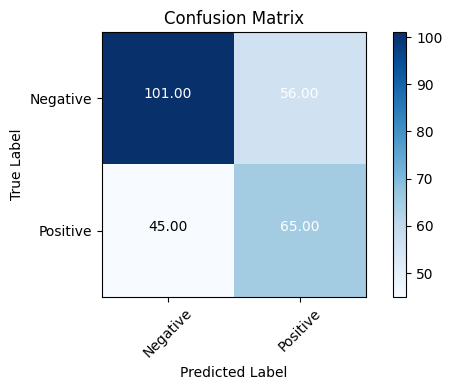

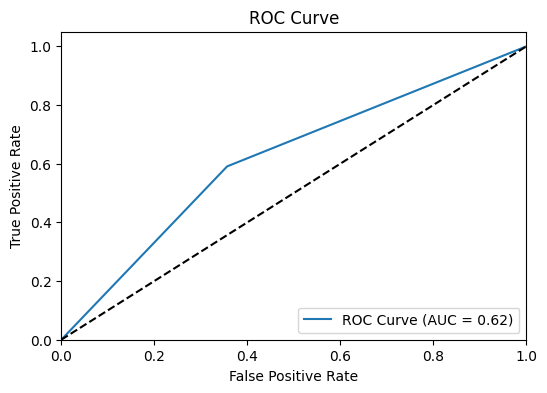

METRICAS EN VALIDATION SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.63      0.69       217
    Positive       0.33      0.48      0.39        83

    accuracy                           0.59       300
   macro avg       0.55      0.56      0.54       300
weighted avg       0.64      0.59      0.61       300



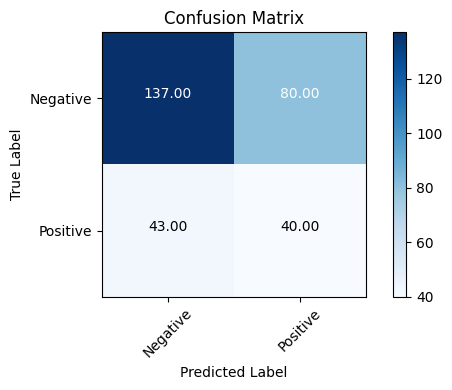

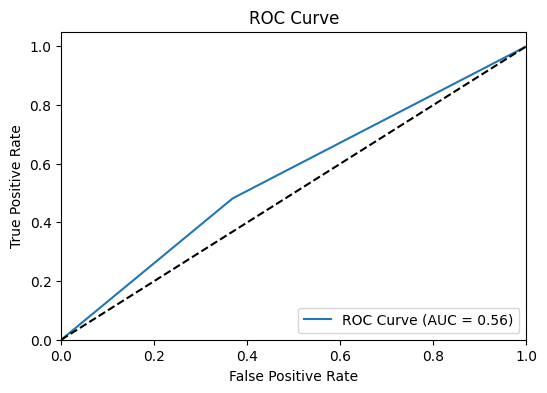

Nuevas métricas agregadas y guardadas en combined_metrics.csv
Experimento completado.
Starting experiment for model: XGBClassifier.
METRICAS EN TESTING SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.73      0.73       157
    Positive       0.62      0.63      0.62       110

    accuracy                           0.69       267
   macro avg       0.68      0.68      0.68       267
weighted avg       0.69      0.69      0.69       267



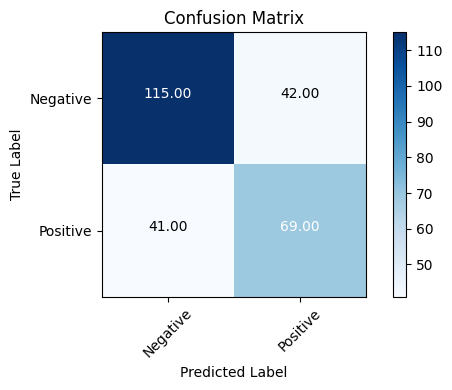

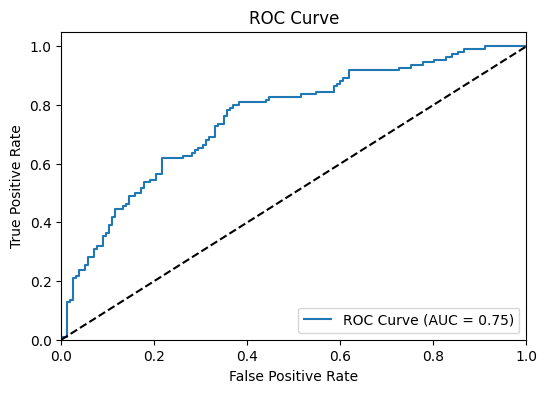

METRICAS EN VALIDATION SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78       217
    Positive       0.44      0.46      0.45        83

    accuracy                           0.69       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.69      0.69      0.69       300



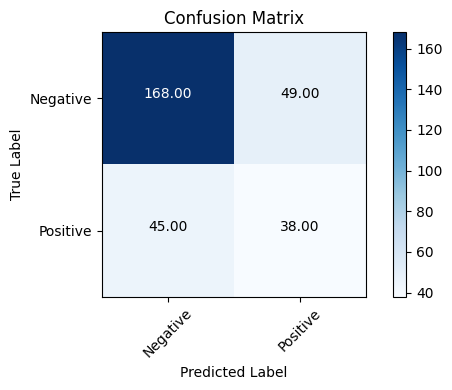

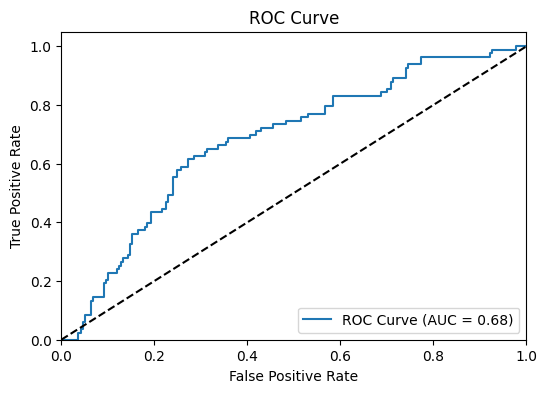

Nuevas métricas agregadas y guardadas en combined_metrics.csv
Experimento completado.
Starting experiment for model: RandomForestClassifier.
METRICAS EN TESTING SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.73      0.74       157
    Positive       0.63      0.66      0.65       110

    accuracy                           0.70       267
   macro avg       0.70      0.70      0.70       267
weighted avg       0.71      0.70      0.71       267



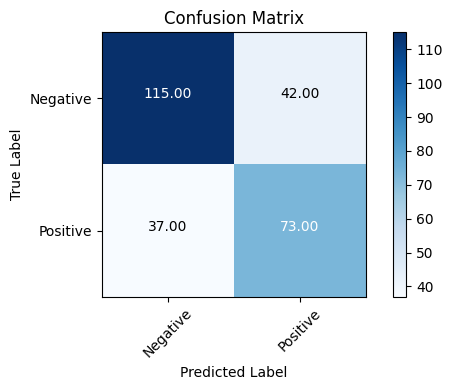

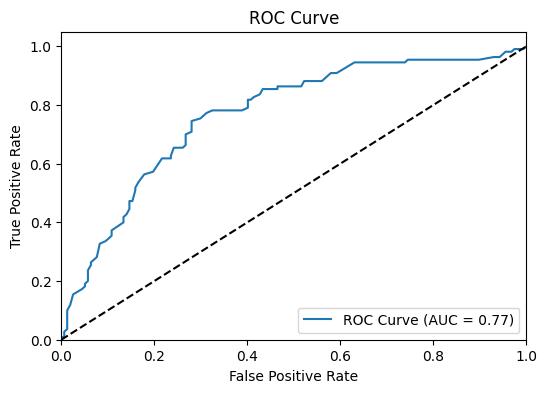

METRICAS EN VALIDATION SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81       217
    Positive       0.50      0.52      0.51        83

    accuracy                           0.72       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.73      0.72      0.72       300



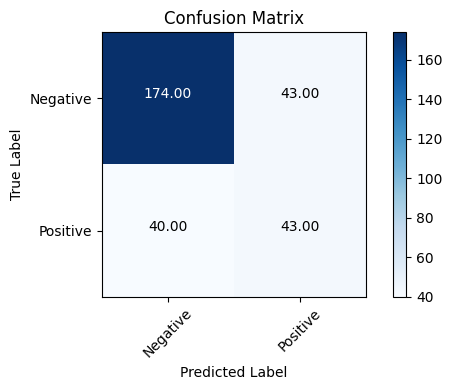

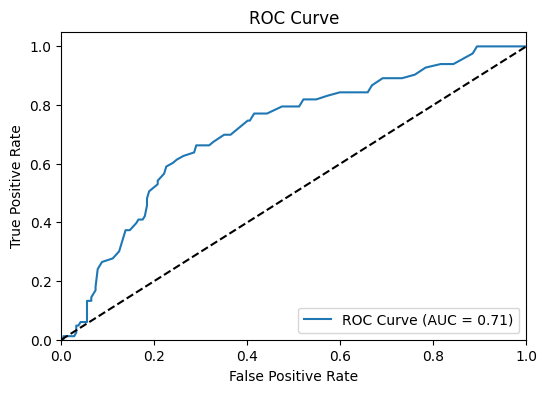

Nuevas métricas agregadas y guardadas en combined_metrics.csv
Experimento completado.
Starting experiment for model: GradientBoostingClassifier.
METRICAS EN TESTING SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.76      0.76       157
    Positive       0.65      0.65      0.65       110

    accuracy                           0.71       267
   macro avg       0.70      0.70      0.70       267
weighted avg       0.71      0.71      0.71       267



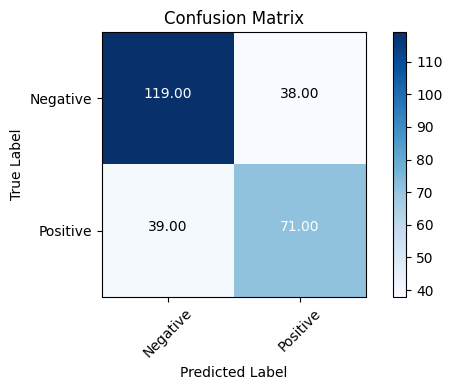

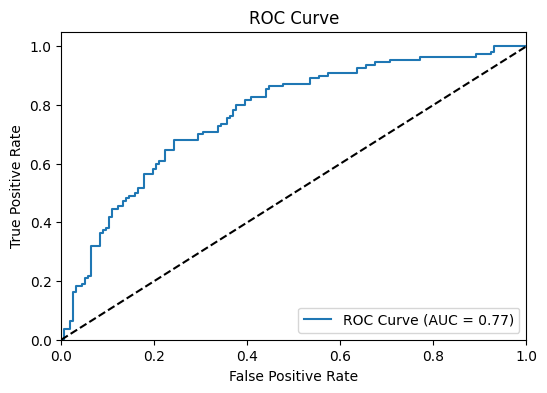

METRICAS EN VALIDATION SET
Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80       217
    Positive       0.47      0.45      0.46        83

    accuracy                           0.71       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.70      0.71      0.70       300



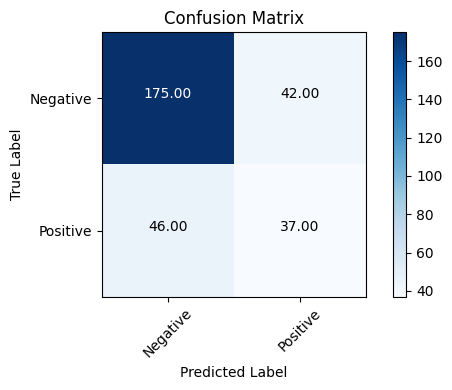

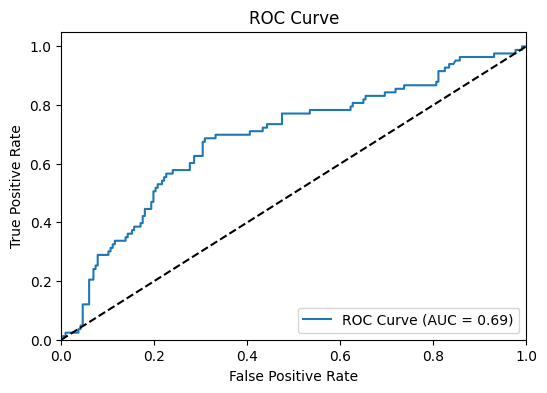

Nuevas métricas agregadas y guardadas en combined_metrics.csv
Experimento completado.


In [13]:
run_experiments(models, datasets, params)